<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/04%20-%20ML/01_linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install clickhouse-driver --q
from clickhouse_driver import Client
from google.colab import userdata

In [ ]:
!pip install -U scikit-learn --q
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Реквизиты для подключения к БД
user = 'hardda_student_alekse-fomin'
password = userdata.get('HA[hardda_student_alekse-fomin]')
host='clickhouse.lab.karpov.courses'
port=9000
database_r='hardda'

In [ ]:
# Соединение
client_r = Client(host=host, port=port, user=user,
                password=password, database=database_r)

In [ ]:
sql = f"""
SELECT
  payment_date,
  -sum(amount) as volume
FROM user_transactions
WHERE type in ('basic sale', 'fast sale', 'quick sale')
GROUP BY payment_date
ORDER BY payment_date
"""
result, columns = client_r.execute(sql, with_column_types=True)
data = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])


In [ ]:
data['payment_date'] = pd.to_datetime(data['payment_date'])

In [ ]:
data

,payment_date,volume
0,2021-02-02,3396867
1,2021-02-03,3504675
2,2021-02-04,3321098
3,2021-02-05,3317318
4,2021-02-06,2763316
...,...,...
506,2023-01-27,7606314
507,2023-01-28,6243591
508,2023-01-29,6866600
509,2023-01-30,8337223


In [ ]:
dates = pd.date_range(start=data['payment_date'].min(), end=data['payment_date'].max())
df = dates.to_frame(name='payment_date', index=False).merge(data, on='payment_date', how='left').sort_values('payment_date')

1. Заполним данные в TS, отсутствующие за какие-то даты, нулями.

2. Фиксируем дату, на которую хотим сделать прогноз - это "будущее, в которое нам нужно смотреть с горизонтом в 30 дней".

3. Отступаем от этой даты на 30 дней и смотрим на значение фичей временного ряда на тот момент.

4. Среди фичей мы предлагаем выделить следующие:

=1, если сб или вск, =0 иначе
лаги к дате из первого пункта шириной 30, 61, 91 дней - фактически, значение временного ряда в момент из пункта 3, за 31 и за 61 день до него.
экспоненциальное скользящее среднее с окном 7/30/91 дней в дату из пункта 3.
5. Убираем из полученного датасета все строки, содержащие NaN. Их можно было бы обработать, а не удалять, но опустим пока этот шаг.

6. Решаем задачу как обычную задачу обучения с учителем, имея фичи на текущий день, с таргетом, равным значению временного ряда через 30 дней.

In [ ]:
df.fillna(0, inplace=True)
df

,payment_date,volume
0,2021-02-02,3396867.0
1,2021-02-03,3504675.0
2,2021-02-04,3321098.0
3,2021-02-05,3317318.0
4,2021-02-06,2763316.0
...,...,...
724,2023-01-27,7606314.0
725,2023-01-28,6243591.0
726,2023-01-29,6866600.0
727,2023-01-30,8337223.0


In [ ]:
def generate_features_for_series(
    data: pd.DataFrame,
    date_colname='payment_date',
    value_colname= 'volume'
):


    data_ = data.copy()
    data_.sort_values(date_colname, inplace=True)

    ### 1)
    data_['weekday'] = data_[date_colname].dt.weekday
    data_.loc[data_['weekday'].isin([5, 6]), 'is_holiday'] = 1
    data_['is_holiday'] = data_['is_holiday'].fillna(0)
    data_.drop('weekday', axis=1, inplace=True)


    ### 2, 3, 4)
    data_['lag_30d'] = data_[value_colname].shift(30)
    data_['lag_61d'] = data_[value_colname].shift(61)
    data_['lag_91d'] = data_[value_colname].shift(91)


    ### 5, 6, 7)
    data_['rolling_7d'] = data_['lag_30d'].ewm(span=7).mean()
    data_['rolling_30d'] = data_['lag_30d'].ewm(span=30).mean()
    data_['rolling_91d'] = data_['lag_30d'].ewm(span=91).mean()



    ### Уберем Nan'ы
    data_.dropna(inplace=True)

    return data_

In [ ]:
df = generate_features_for_series(df)

In [ ]:
df

,payment_date,volume,is_holiday,lag_30d,lag_61d,lag_91d,rolling_7d,rolling_30d,rolling_91d
91,2021-05-04,4585501.0,0.0,0.0,3298677.0,3396867.0,1.052007e+06,1.837514e+06,2.137795e+06
92,2021-05-05,4842622.0,0.0,3707972.0,2632327.0,3504675.0,1.715998e+06,1.960023e+06,2.183332e+06
93,2021-05-06,4289897.0,0.0,3929579.0,2489894.0,3321098.0,2.269393e+06,2.088896e+06,2.233610e+06
94,2021-05-07,0.0,0.0,3719324.0,2604353.0,3317318.0,2.631876e+06,2.195482e+06,2.276087e+06
95,2021-05-08,0.0,1.0,0.0,2141489.0,2763316.0,1.973907e+06,2.052080e+06,2.211456e+06
...,...,...,...,...,...,...,...,...,...
724,2023-01-27,7606314.0,0.0,5576730.0,5560131.0,6605566.0,4.042208e+06,4.284195e+06,4.362926e+06
725,2023-01-28,6243591.0,1.0,4879158.0,6110948.0,5888153.0,4.251446e+06,4.322580e+06,4.374148e+06
726,2023-01-29,6866600.0,1.0,3997769.0,6505339.0,6081790.0,4.188027e+06,4.301624e+06,4.365966e+06
727,2023-01-30,8337223.0,0.0,2698006.0,0.0,0.0,3.815521e+06,4.198165e+06,4.329706e+06


## Задание 4 и 5
Выполним вычисления на всем датафрейме и найдем MSE и MAE.
(Выразить значение в целых млн)

In [ ]:
y = df.volume
X = df.drop(['payment_date', 'volume'], axis=1)

In [ ]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [ ]:
preds = model.predict(X)

In [ ]:
MSE = mean_squared_error(y, preds).round(-6)
MAE = mean_absolute_error(y, preds).round(-6)

In [ ]:
MSE, MAE

(7659275000000.0, 2000000.0)

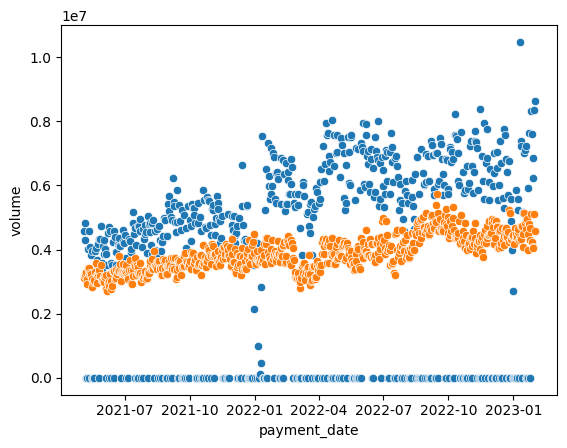

In [ ]:
sns.scatterplot(data=df, x='payment_date', y='volume');
sns.scatterplot(x=df['payment_date'], y=preds);

## Задание 6
В машинном обучении бывает полезно считать асимметричные метрики. Особенно в случаях, когда мы хотим дать лишь нижнюю или верхнюю оценку при прогнозировании. Например, прекрасный пример такой метрики - применение квадратичной ошибки при перепрогнозе, а абсолютной при недопрогнозе на каждом объекте (или наоборот). Далее - усреднение посчитанных по каждому объекту loss'ов. Формулу можно было бы записать следующим образом:

$\text{Asymmetric} = [\text{Prediction} > \text{Target}] \cdot (\text{Prediction} - \text{Target})^2 + [\text{Prediction} < \text{Target}] \cdot |\text{Prediction} - \text{Target}|$


In [ ]:
def asymmetric_loss(prediction, target):
    return np.where(prediction > target,
             (prediction - target) ** 2,
             abs(prediction - target)).mean()

In [ ]:
# Посчитайте эту метрику. "Округлите" выразите значение в миллионах
asymmetric_loss(preds, y).round(-6) // 1e6

4838182.0

## Задание 7
Если мы захотим наказывать нашу модель за недопрогноз, то в формуле изменятся знаки “больше”/”меньше” на противоположные:

In [ ]:
def asymmetric_loss2(prediction, target):
    return np.where(prediction < target,
             (prediction - target) ** 2,
             abs(prediction - target)).mean()

In [ ]:
asymmetric_loss2(preds, y).round(-6) // 1e6

2821095.0

## Задание 8
Теперь перейдем к интерпретации фичей.

У каких топ-3 фичей наибольший негативный вклад в формирование прогноза? Иными словами, выберите те фичи, увеличение которых на единицу (при прочих равных) с наибольшей силой уменьшит значение прогноза.

In [ ]:
d = dict(zip(X.columns, model.coef_))

In [ ]:
d

{'is_holiday': -255284.49616907266,
 'lag_30d': -0.025142340582798822,
 'lag_61d': -0.05401974302169127,
 'lag_91d': -0.07336742763875188,
 'rolling_7d': 0.32066586449455364,
 'rolling_30d': -1.5811431944803394,
 'rolling_91d': 2.042672291420454}

In [ ]:
sorted(d, key=d.get)[:3]

['is_holiday', 'rolling_30d', 'lag_91d']

## Задание 9
Вычислите, чему будет равен прогноз вашей модели, если за некоторый день все фичи, которые мы посчитали, имеют значение 1?

Введите ответ в поле ниже с точностью до трех знаков в десятичной части.

In [ ]:
pred = np.append(model.coef_, model.intercept_).sum()

In [ ]:
print(f"если за некоторый день все фичи, которые мы посчитали, имеют значение 1, прогноз равен {pred:.3f}")

если за некоторый день все фичи, которые мы посчитали, имеют значение 1, прогноз равен 1486271.702


## Задание 10
Каким окажется прогноз, если выбранный день не являлся выходным?

Введите ответ в поле ниже с точностью до трех знаков в десятичной части.

In [ ]:
# т.к is_holiday это первый коэффициент в модели
pred = np.append(model.coef_[1:], model.intercept_).sum()

In [ ]:
print(f"если выбранный день не являлся выходным, прогноз будет равен {pred:.3f}")

если выбранный день не являлся выходным, прогноз будет равен 1741556.199


## Задание 11
Мы можем задизайнить нашу модель как "прогноз TS есть сумма прогнозов всех его компонентов":
$a^*(TS) = a^*(TS_1) + a^*(TS_2) + a^*(TS_3)$

В нашем случае компонентой временного ряда может являться разбиение выручки по типам каналов, по которым была совершена транзакция.

У нас их три - basic sale, fast sale, quick sale. В отдельности значения по датам в каждом из этих каналов - временной ряд. Можем отдельно их прогнозировать, а "оценку" далее сложить.

Обучите новую модель и замерьте MSE финального прогноза.

Округлите значение до миллионов

In [ ]:
sql = f"""
SELECT
  payment_date,
  type,
  -sum(amount) as volume
FROM user_transactions
WHERE type in ('basic sale', 'fast sale', 'quick sale')
GROUP BY payment_date, type
ORDER BY payment_date
"""
result, columns = client_r.execute(sql, with_column_types=True)
data = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [ ]:
data['payment_date'] = pd.to_datetime(data['payment_date'])

In [ ]:
df_basic = data.query("type == 'basic sale'")[['payment_date', 'volume']]
df_fast = data.query("type == 'fast sale'")[['payment_date', 'volume']]
df_quick = data.query("type == 'quick sale'")[['payment_date', 'volume']]

In [ ]:
df_basic_ = generate_features_for_series(df_basic)
df_fast_ = generate_features_for_series(df_fast)
df_quick_ = generate_features_for_series(df_quick)

In [ ]:
# function trains model and returns prediction
def predict(data: pd.DataFrame, y='volume', drop_cols=['payment_date', 'volume']):
    y = data[y]
    X = data.drop(drop_cols, axis=1)
    model = LinearRegression()
    model.fit(X, y)
    preds = model.predict(X)
    return preds

In [ ]:
# function adds missed dates to dataframe and fills NAs with provided values
def fill_dates(data: pd.DataFrame, date_field='payment_date', fill_value=0):
    dates = pd.date_range(start=data[date_field].min(), end=data[date_field].max())
    df = dates.to_frame(name=date_field, index=False).merge(data, on=date_field, how='left').sort_values(date_field)
    return df.fillna(fill_value)

In [ ]:
preds = predict(generate_features_for_series(fill_dates(df_basic))) + \
predict(generate_features_for_series(fill_dates(df_fast))) + \
predict(generate_features_for_series(fill_dates(df_quick)))

In [ ]:
MSE = mean_squared_error(y, preds).round(-6)
MAE = mean_absolute_error(y, preds).round(-6)

In [ ]:
MSE // 1e6

7648099.0

In [ ]:
7659275000000 // 1e6

7659275.0